In [1]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

In [9]:
def exchangerate_processing(filename):
    """
    Reads in a given file and cleans up all the missing values
    
    Inputs: filename 
    Outputs: exchangevalue
    """
    # Reads in currency exchange rate data
    dataset = pd.read_csv('data/'+filename) # Reads in CSV file
    exchangevalues = dataset.iloc[:, 1:2] # Selects columns

    # Replaces missing data (represented by '.') with zeros ('0')
    mask=exchangevalues=='.'
    exchangevalues[mask] = '0'

    # Reformats columns into floats
    exchangevalues=np.array(exchangevalues)
    exchangevalues=np.matrix([float(x) for x in exchangevalues])
    exchangevalues=exchangevalues.transpose()

    # Fills in missing and outlier values by taking average between adjacent timesteps
    mean,std=np.mean(exchangevalues),np.std(exchangevalues) # Computes mean and std
    indices = [i for i ,x in enumerate(exchangevalues) if x<mean-2.5*std] # Finds indices of zero and outlier values
    for i in indices:
        # First, checks the initial and final elements of the list
        # If any of these are zero, set them to be equal to their adjacent values
        if i==0:
            exchangevalues[i] = exchangevalues[i+1]
        elif i==len(exchangevalues)-1:
            exchangevalues[i] = exchangevalues[i-1]

        # For the rest of the elements, set them to be the average of their adjacent values
        exchangevalues[i] = 0.5*(exchangevalues[i+1]+exchangevalues[i-1]) 
    
    return exchangevalues

In [126]:
# Reads in all the files
input_files=['DEXCAUS.csv', 'DEXJPUS.csv', 'DEXMXUS.csv',\
             'DEXUSUK.csv', 'DEXCHUS.csv', 'DEXKOUS.csv',\
             'DEXUSEU.csv']

# Contructs the training set
training_set=np.array([exchangerate_processing(x) for x in input_files])
training_set = np.reshape(training_set, (training_set.shape[0], training_set.shape[1]))
training_set = training_set.T
print(training_set.shape)  

/home/ansonl/.local/lib/python3.5/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
/home/ansonl/.local/lib/python3.5/site-packages/pandas/core/frame.py:3163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._where(-key, value, inplace=True)


(2610, 7)


In [182]:
# Train/test set parameters
N_timesteps = 60 # Number of timesteps in each training epoch
N_total_timesteps = training_set.shape[0] # The total number of timesteps in the dataset
N_test_timesteps = int(0.15*N_total_timesteps) # Number of timesteps for the test set

# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)
print('training_set_scaled shape',training_set_scaled.shape)

# Creates a data structure with N timesteps and 1 output
X_train ,y_train = [], []
for i in range(N_timesteps, N_total_timesteps-N_test_timesteps):
    X_train.append(training_set_scaled[i-N_timesteps:i,:])
    y_train.append(training_set_scaled[i,:])
X_train, y_train = np.array(X_train), np.array(y_train)
print('X_train shape',X_train.shape)
print('y_train shape',y_train.shape)

X_test, y_test = [], []
for i in range(N_total_timesteps-N_test_timesteps, len(training_set)):
    X_test.append(training_set_scaled[i-N_timesteps:i,:])
    y_test.append(training_set_scaled[i,:])
X_test, y_test = np.array(X_test), np.array(y_test)

# Reshaping
#X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
#X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
#y_train = np.reshape(y_train, (y_train.shape[0], 1))
#y_test = np.reshape(y_test, (y_test.shape[0], 1))

print('X_test shape',X_test.shape)
print('y_test shape',y_test.shape)

training_set_scaled shape (2610, 7)
X_train shape (2159, 60, 7)
y_train shape (2159, 7)
X_test shape (391, 60, 7)
y_test shape (391, 7)


**Parameter tuning the RNN**

- Increase the number of timesteps. Note that this also tends to increase the phase delay of the prediction.
- Adding more LSTM layers
- Adding more neurons to the LSTM layers
- For parameter tuning, use scoring = 'neg_mean_squared_error'

In [183]:
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

# Initialising the RNN
regressor = Sequential()

# Define network parameters
hidden_units=20
dropout_rate=0.4

regressor.add(LSTM(units = hidden_units, return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))
regressor.add(Dropout(dropout_rate))

#regressor.add(LSTM(units = hidden_units, return_sequences = True))
#regressor.add(Dropout(dropout_rate))

#regressor.add(LSTM(units = hidden_units, return_sequences = True))
#regressor.add(Dropout(dropout_rate))

regressor.add(LSTM(units = hidden_units))
regressor.add(Dropout(dropout_rate))

regressor.add(Dense(units = X_train.shape[2]))

regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')


In [150]:
# RNN architecture details
regressor.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_44 (LSTM)               (None, 60, 20)            2240      
_________________________________________________________________
dropout_44 (Dropout)         (None, 60, 20)            0         
_________________________________________________________________
lstm_45 (LSTM)               (None, 60, 20)            3280      
_________________________________________________________________
dropout_45 (Dropout)         (None, 60, 20)            0         
_________________________________________________________________
lstm_46 (LSTM)               (None, 20)                3280      
_________________________________________________________________
dropout_46 (Dropout)         (None, 20)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 7)                 147       
Total para

In [184]:
# Fit the RNN to the Training set
history=regressor.fit(X_train, y_train, validation_split=0.2, epochs = 20, batch_size = 64)

Train on 1727 samples, validate on 432 samples
Epoch 1/20
1727/1727 [==============================] - 13s 8ms/step - loss: 0.3513 - val_loss: 0.1480
Epoch 2/20
1727/1727 [==============================] - 2s 1ms/step - loss: 0.1447 - val_loss: 0.0554
Epoch 3/20
1727/1727 [==============================] - 2s 1ms/step - loss: 0.0915 - val_loss: 0.0542
Epoch 4/20
1727/1727 [==============================] - 2s 1ms/step - loss: 0.0733 - val_loss: 0.0499
Epoch 5/20
1727/1727 [==============================] - 2s 1ms/step - loss: 0.0634 - val_loss: 0.0471
Epoch 6/20
1727/1727 [==============================] - 2s 1ms/step - loss: 0.0560 - val_loss: 0.0468
Epoch 7/20
1727/1727 [==============================] - 2s 1ms/step - loss: 0.0522 - val_loss: 0.0457
Epoch 8/20
1727/1727 [==============================] - 3s 2ms/step - loss: 0.0486 - val_loss: 0.0379
Epoch 9/20
1727/1727 [==============================] - 2s 1ms/step - loss: 0.0440 - val_loss: 0.0316
Epoch 10/20
1727/1727 [===========

dict_keys(['loss', 'val_loss'])


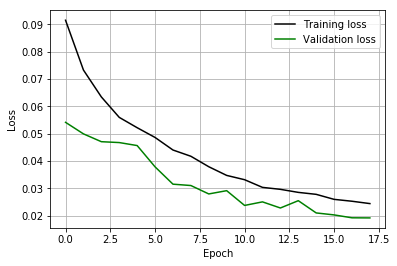

In [185]:
# Plots loss vs. epoch from the training

# list all data in history
print(history.history.keys())

# Sets the number of epochs to exclude at the beginning since they tend to be large
exclude_epochs = 2

plt.plot(history.history['loss'][exclude_epochs:],'k-',label='Training loss')
plt.plot(history.history['val_loss'][exclude_epochs:],'g-',label='Validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc=1)
plt.grid(True)
plt.show()


In [186]:
# Makes preductions using the test set and the trained RNN model
predicted_values = regressor.predict(X_test)

# Inverts feature scaling transformation
y_train = sc.inverse_transform(y_train)
y_test = sc.inverse_transform(y_test)
predicted_values = sc.inverse_transform(predicted_values)

print(y_train.shape,y_test.shape,predicted_values.shape)

(2159, 7) (391, 7) (391, 7)


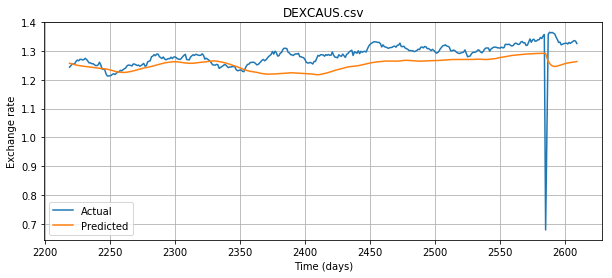

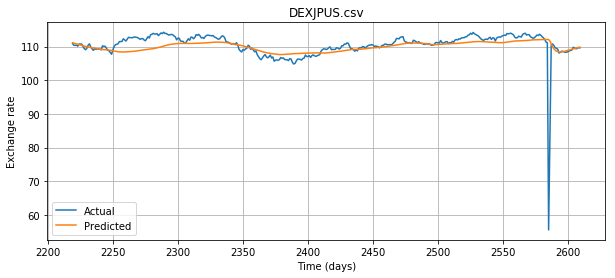

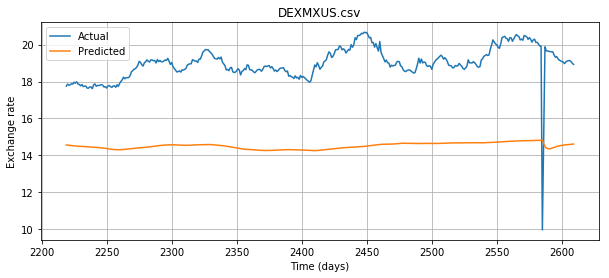

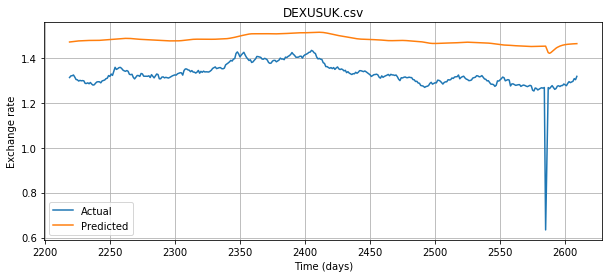

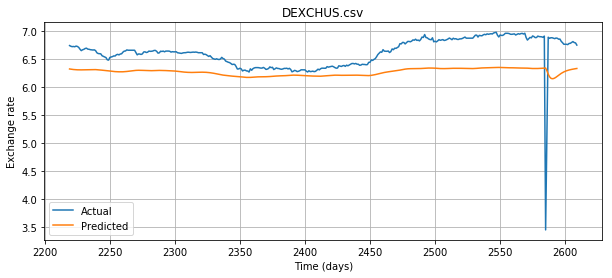

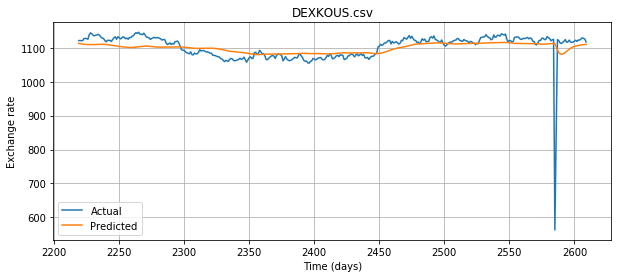

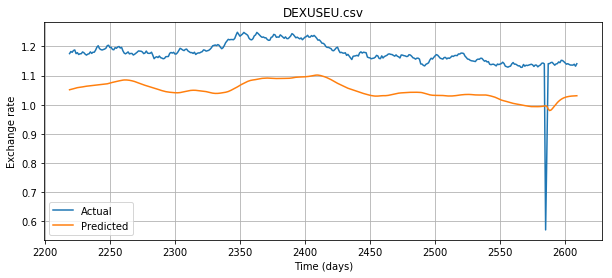

In [187]:
# Does plotting


#plt.plot(range(N_timesteps, len(training_set)-N_test_timesteps),y_train,label = 'Training data')
x_predicted=np.array(range(N_total_timesteps-N_test_timesteps, N_total_timesteps))

# Loops over all the different currencies
for i,x in enumerate(input_files):
    plt.figure(figsize=(10,4))
    plt.plot(x_predicted,y_test[:,i],label = 'Actual')
    plt.plot(x_predicted,predicted_values[:,i],label = 'Predicted')
    plt.title(x)
    plt.xlabel('Time (days)')
    plt.ylabel('Exchange rate')
    plt.legend()
    plt.grid(True)
    plt.show() 

In [8]:
# Saves the trained RNN model
regressor.save('models/'+filename+'.h5')
print('Model saved')

Model saved
